In [65]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import requests
from bs4 import BeautifulSoup

In [66]:
# 그래프 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [67]:
# 네이버 API 인증 정보
client_id = 'YaKyDrFyIZDRfIiRAwBj'
client_secret = 'hknmr5WHGm'

In [68]:
# 업비트 데이터를 가져오는 함수
def fetch_upbit_data(market="KRW-BTC", count=200):
    url = "https://api.upbit.com/v1/candles/days"
    params = {"market": market, "count": count}
    response = requests.get(url, params=params)

    if response.status_code != 200:
        print(f"업비트 API에서 데이터를 가져오지 못했습니다. 상태 코드: {response.status_code}")
        return None

    data = response.json()
    df = pd.DataFrame(data)
    df = df[["candle_date_time_kst", "trade_price"]]
    df.columns = ["date", "price"]
    df["date"] = pd.to_datetime(df["date"]).dt.date
    df.sort_values(by="date", inplace=True)
    return df

In [69]:
# 뉴스 데이터를 가져오는 함수
def fetch_news_data(query, display=10):
    url = f"https://openapi.naver.com/v1/search/news.json?query={query}&display={display}"
    headers = {
        "X-Naver-Client-Id": client_id,
        "X-Naver-Client-Secret": client_secret
    }
    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        print(f"뉴스 API에서 데이터를 가져오지 못했습니다. 상태 코드: {response.status_code}")
        return None

    data = response.json()
    return pd.DataFrame(data['items'])

In [70]:
# 감정 분석을 위한 함수
def analyze_sentiment(texts):
    tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
    model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
    sentiments = []

    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        outputs = model(**inputs)
        sentiment = torch.argmax(outputs.logits, dim=1).item() + 1  # 감정 점수: 1~5
        sentiments.append(sentiment)

    return sentiments

In [71]:
# URL에서 뉴스 제목과 본문을 크롤링하는 함수
def crawl_additional_news(url):
    response = requests.get(url)
    if response.status_code != 200:
        print(f"뉴스 크롤링 실패: 상태 코드 {response.status_code}")
        return None, None

    soup = BeautifulSoup(response.text, "html.parser")

    # 뉴스 제목 크롤링
    title_tag = soup.find("h1")  # 실제 태그와 클래스명을 확인 후 수정
    if title_tag is None:
        title = "제목 없음"
    else:
        title = title_tag.text.strip()

    # 뉴스 본문 크롤링
    content_tag = soup.find("div", class_="content")  # 실제 태그와 클래스명을 확인 후 수정
    if content_tag is None:
        content = "본문 없음"
    else:
        content = content_tag.text.strip()

    return title, content

In [72]:
# BTC/KRW 시장 데이터 가져오기
df_price = fetch_upbit_data()
if df_price is None:
    raise ValueError("업비트 데이터를 가져오지 못했습니다.")

In [73]:
# 뉴스 데이터 가져오기
news_df = fetch_news_data("비트코인")
if news_df is None:
    raise ValueError("뉴스 데이터를 가져오지 못했습니다.")

In [74]:
# 뉴스 데이터 날짜별 처리
news_df['pubDate'] = pd.to_datetime(news_df['pubDate'], errors='coerce')
news_df['date'] = news_df['pubDate'].dt.date
news_df = news_df.dropna(subset=['date'])

In [75]:
# 감정 분석 수행
news_df['sentiment'] = analyze_sentiment(news_df['title'])

In [76]:
# 크롤링할 뉴스 URL 리스트
news_urls = [
    "https://www.g-enews.com/ko-kr/news/article/news_all/202312031530096281e7e8286d56_1/article.html",
    "https://www.yna.co.kr/view/AKR20231007023200002?input=1195m",
    "https://www.hankyung.com/article/2023100952301",
    # 추가 URL을 여기에 입력 가능
]

In [77]:
#추가 뉴스 크롤링 및 데이터 추가
for url in news_urls:
    additional_title, additional_content = crawl_additional_news(url)
    if additional_title:
        additional_sentiment = analyze_sentiment([additional_title])[0]
        print(f"추가 뉴스 제목: {additional_title}")
        print(f"추가 뉴스 감정 점수: {additional_sentiment}")
        # 추가된 뉴스 데이터를 기존 데이터프레임에 병합
        news_df = pd.concat([news_df, pd.DataFrame({"date": [pd.to_datetime("2023-12-03").date()],
                                                    "title": [additional_title],
                                                    "sentiment": [additional_sentiment]})], ignore_index=True)


추가 뉴스 제목: 일론 머스크 관련 ‘밈 토큰’ 급등…가상화폐 생태계 흔들까
추가 뉴스 감정 점수: 3
추가 뉴스 제목: 상반기 국내 가상자산 시총 28조…비트코인 등 회복세에 46%↑
추가 뉴스 감정 점수: 1
추가 뉴스 제목: 금융
추가 뉴스 감정 점수: 4


In [78]:
# 날짜별 평균 감정 점수 계산
sentiment_by_date = news_df.groupby('date')['sentiment'].mean().reset_index()
sentiment_by_date.columns = ['date', 'average_sentiment']

In [79]:
# 감정 점수 병합
merged_df = pd.merge(df_price, sentiment_by_date, on='date', how='left')
merged_df['average_sentiment'].fillna(2.5, inplace=True)

C:\Users\kgg07\AppData\Local\Temp\ipykernel_26132\731998398.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['average_sentiment'].fillna(2.5, inplace=True)


In [80]:
# 데이터 스케일링
scaler = MinMaxScaler()
scaler.fit(df_price[['price']])
merged_df['scaled_price'] = scaler.transform(merged_df['price'].values.reshape(-1, 1))
merged_df['scaled_sentiment'] = scaler.transform(merged_df['average_sentiment'].values.reshape(-1, 1))

C:\Users\kgg07\anaconda3\envs\learning3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\kgg07\anaconda3\envs\learning3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [81]:
# 멀티모달 데이터 생성 함수 정의
def create_multimodal_sequences(prices, sentiments, seq_length):
    sequences = []
    labels = []
    for i in range(len(prices) - seq_length):
        seq = np.column_stack((prices[i:i + seq_length], sentiments[i:i + seq_length]))
        label = prices[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [82]:
# 멀티모달 데이터 준비
sequence_length = 10
X, y = create_multimodal_sequences(
    merged_df['scaled_price'].values,
    merged_df['scaled_sentiment'].values,
    sequence_length
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
# GRU 모델 생성
model = Sequential([
    GRU(128, input_shape=(sequence_length, 2), return_sequences=True),
    Dropout(0.2),
    GRU(64),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

C:\Users\kgg07\anaconda3\envs\learning3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [84]:
# 모델 학습
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=16,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - loss: 0.0907 - val_loss: 0.0135
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0149 - val_loss: 0.0049
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0097 - val_loss: 0.0037
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0089 - val_loss: 0.0026
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0058 - val_loss: 0.0026
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0051 - val_loss: 0.0038
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0098 - val_loss: 0.0026
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0048 - val_loss: 0.0027
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0058 - val_loss: 0.0024
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0054 - val_loss: 0.0034
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0053 - val_loss: 0.0044
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.

In [85]:
# 예측값과 실제값 복원
predictions = model.predict(X_test)
original_scale_predictions = scaler.inverse_transform(predictions)
original_scale_y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000017B30B172E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 704ms/step


In [86]:
# 결과 출력
print("샘플 예측값과 실제값:")
for pred, true in zip(original_scale_predictions[:5], original_scale_y_test[:5]):
    print(f"예측값: {pred[0]:,.2f}, 실제값: {true[0]:,.2f}")

샘플 예측값과 실제값:
예측값: 135,012,432.00, 실제값: 128,783,000.00
예측값: 134,376,576.00, 실제값: 133,802,000.00
예측값: 84,819,664.00, 실제값: 84,631,000.00
예측값: 80,556,456.00, 실제값: 86,397,000.00
예측값: 77,903,344.00, 실제값: 80,930,000.00


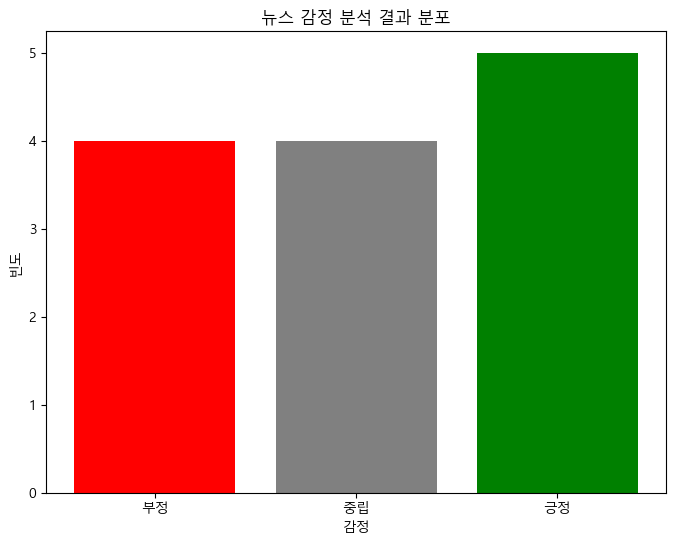

In [87]:
# 뉴스 감정 분석 결과 시각화
sentiment_counts = news_df['sentiment'].value_counts().sort_index()
categories = ['부정', '중립', '긍정']
counts = [
    sentiment_counts.get(1, 0) + sentiment_counts.get(2, 0),
    sentiment_counts.get(3, 0),
    sentiment_counts.get(4, 0) + sentiment_counts.get(5, 0)
]
plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color=['red', 'gray', 'green'])
plt.title('뉴스 감정 분석 결과 분포')
plt.xlabel('감정')
plt.ylabel('빈도')
plt.show()

In [ ]:
# 예측값과 실제값 비교 시각화
plt.figure(figsize=(10, 6))
plt.plot(merged_df['date'][-len(original_scale_y_test):], original_scale_y_test, label='실제 가격', color='blue', alpha=0.6)
plt.plot(merged_df['date'][-len(original_scale_predictions):], original_scale_predictions, label='예측 가격', color='red', alpha=0.6)

# Y축 포맷 설정
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.title('실제 비트코인 가격과 예측 가격 비교')
plt.xlabel('날짜')
plt.ylabel('가격 (KRW)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()